# Image Background Removal using OpenCV

When the object is the image alone, neural networks for image classification will be able to train faster and better. As a result, eliminating the backgrounds from photographs is a very useful pre-processing step.


# Importing The Required Liberaries

In [353]:
import os
import pickle
import numpy as np
from PIL import Image

In [354]:
import numpy as np
import cv2

In [355]:
from cv2 import ximgproc

The image of this painting is evident that the background is composed of wall and the color shade of the painting and the wall are nearly same. 

In [4]:
from IPython.display import Image
Image(url= "im1.jpg")

# First Step: Gaussian Blur

To minimise noise and detail, convert the image to a vector and then preprocess it with Gaussian blur. This function is included in the openCV library. It's also worth noting that both height and width must be positive numbers.

In [532]:
image_vec = cv2.imread('/Users/siddhantbhambri/Downloads/qst2_w1/00029.jpg', 1)
g_blurred = cv2.GaussianBlur(image_vec, (5, 5), 0)

# Second Step: Edge Detection

In this phase, edge detection is accompanied by a pre-trained Forest Model "model.yml." This enables more precise edge detection. Furthermore, if the image is in colour, you must process each colour channel separately before combining them.

In [533]:
blurred_float = g_blurred.astype(np.float32) / 255.0
edgeDetector = cv2.ximgproc.createStructuredEdgeDetection("/Users/siddhantbhambri/Downloads/model.yml")
edges = edgeDetector.detectEdges(blurred_float) * 255.0
cv2.imwrite('edge_raw.jpg', edges)

True

# Third Step: Filter Out Salt and Pepper Noise using Median Filter

Salt and peeper noise, often known as 'impulse noise,' is a type of noise. Sharp disruptions in the visual signal can cause it. It appears as a pattern of white and black pixels. The median filter will be used to address this. It works by removing any intensities that are less than the average of all intensities in the image.

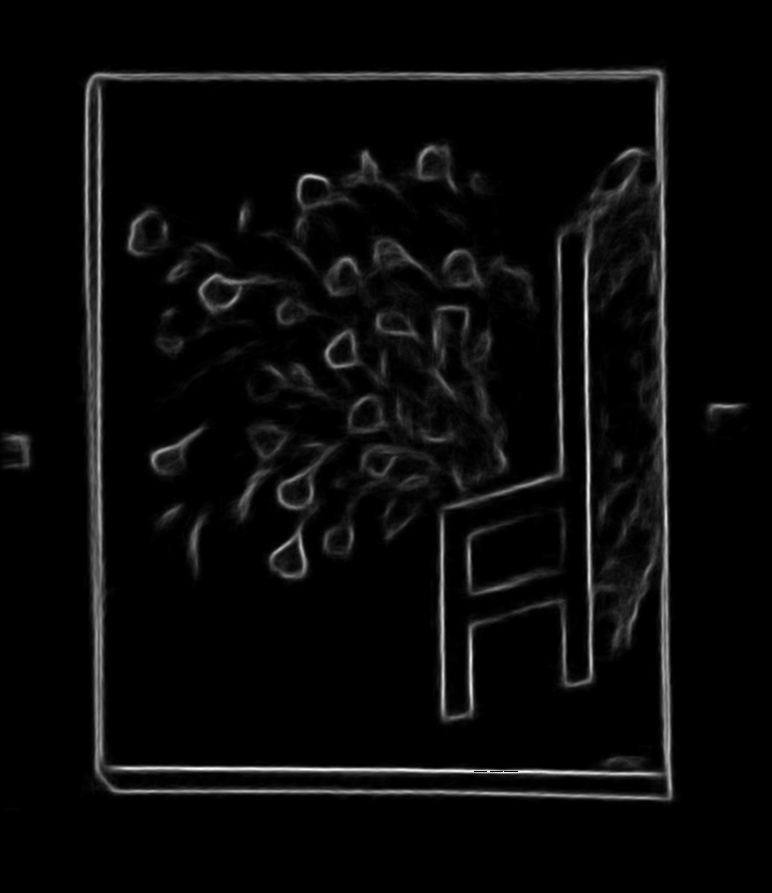

In [534]:
def SaltPepperNoise(edgeImg):

    count = 0
    lastMedian = edgeImg
    median = cv2.medianBlur(edgeImg, 3)
    while not np.array_equal(lastMedian, median):
        zeroed = np.invert(np.logical_and(median, edgeImg))
        edgeImg[zeroed] = 0
        count = count + 1
        if count > 70:
            break
        lastMedian = median
        median = cv2.medianBlur(edgeImg, 3)
edges_ = np.asarray(edges, np.uint8)
SaltPepperNoise(edges_)
cv2.imwrite('edge.jpg', edges_)
Image.open('edge.jpg').convert('RGB')

# Fourth step: Find Significant Contours

Contour in image is an outline on the objects present in the image. The significance of the objects depend on the requirement and threshold you choose. Any contour within another contour is treated as the ‘child’ contour. And this can occur at higher levels. OpenCV returns the contour tree as a flat array with tuples indexed to its parents contour. Remove any contours that do not take at least 5% of the image in area.

In [535]:
def findSignificantContour(edgeImg):
    image, contours, hierarchy = cv2.findContours(
        edgeImg,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
        # Find level 1 contours
    level1Meta = []
    for contourIndex, tupl in enumerate(hierarchy[0]):
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl.copy(), 0, [contourIndex])
            level1Meta.append(tupl)
# From among them, find the contours with large surface area.
    contoursWithArea = []
    for tupl in level1Meta:
        contourIndex = tupl[0]
        contour = contours[contourIndex]
        area = cv2.contourArea(contour)
        contoursWithArea.append([contour, area, contourIndex])
    contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
    largestContour = contoursWithArea[0][0]
    return largestContour

In [536]:
contour = findSignificantContour(edges_)
# Draw the contour on the original image
contourImg = np.copy(image_vec)
cv2.drawContours(contourImg, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)
cv2.imwrite('contour.jpg', contourImg)

True

# Fifth Step: Masking Probable Background

Finally, the background can be removed by filling shapes with a mask.

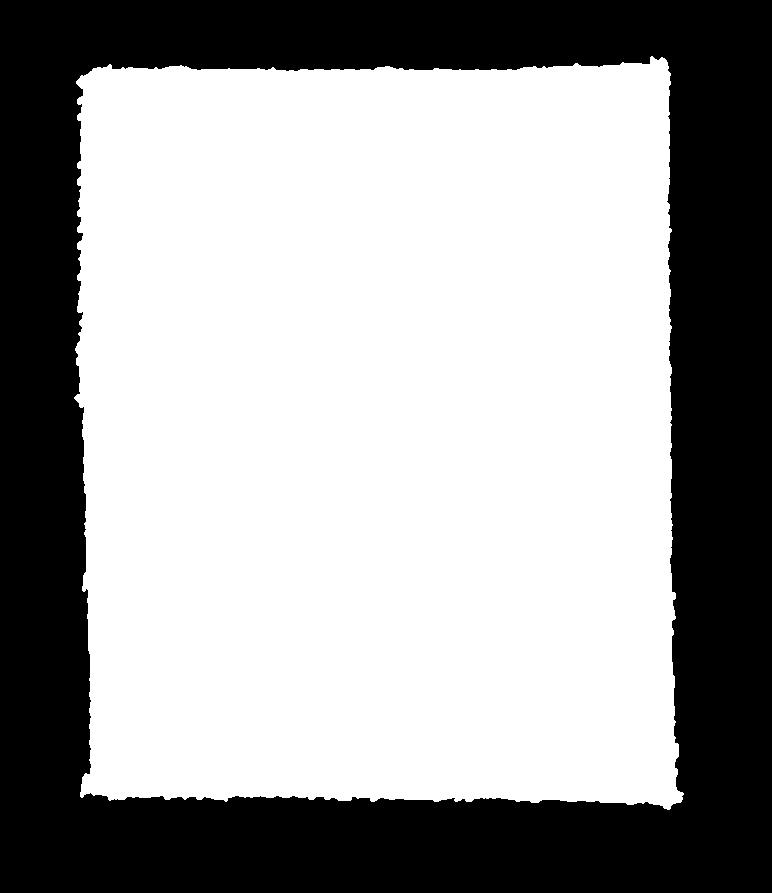

In [537]:
mask = np.zeros_like(edges_)
cv2.fillPoly(mask, [contour], 255)
# calculate sure foreground area by dilating the mask
mapFg = cv2.erode(mask, np.ones((5, 5), np.uint8), iterations=10)
# mark inital mask as "probably background"
# and mapFg as sure foreground
trimap = np.copy(mask)
trimap[mask == 0] = cv2.GC_BGD
trimap[mask == 255] = cv2.GC_PR_BGD
trimap[mapFg == 255] = cv2.GC_FGD
# visualize trimap
trimap_print = np.copy(trimap)
trimap_print[trimap_print == cv2.GC_PR_BGD] = 128
trimap_print[trimap_print == cv2.GC_FGD] = 255
image = (trimap_print>0).astype(np.uint8)*255
cv2.imwrite('/Users/siddhantbhambri/Downloads/qst2_w1/generated_masks/00029.png', image)
Image.open('/Users/siddhantbhambri/Downloads/qst2_w1/generated_masks/00029.png').convert('RGB')

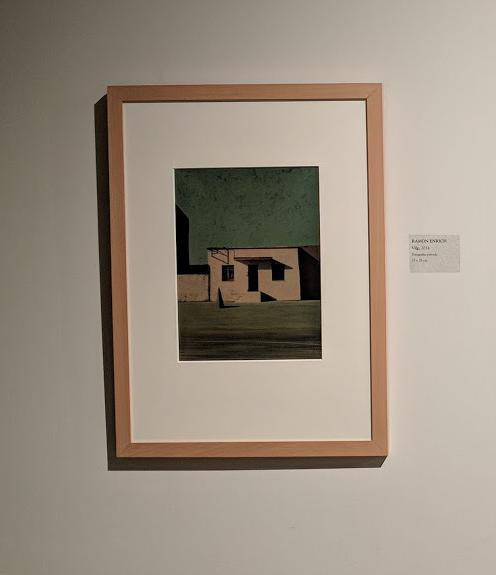

In [327]:

Image.open('/Users/siddhantbhambri/Downloads/qsd2_w1/00029.jpg').convert('RGB')

In [66]:
image = (trimap_print>0).astype(np.uint8)*255

In [352]:
queryset_dir = "/Users/siddhantbhambri/Downloads/qsd2_w1"
query_set = [fname for fname in sorted(os.listdir(queryset_dir)) if fname.endswith(".png")]
queryset_dir_g = "/Users/siddhantbhambri/Downloads/qsd2_w1/generated_masks"
query_set_g = [fname for fname in sorted(os.listdir(queryset_dir_g)) if fname.endswith(".png")]
PRF = []
Prec = []
Rec = []
F1 = []
for q in query_set:
    image_vec = cv2.imread('/Users/siddhantbhambri/Downloads/qsd2_w1/{}'.format(q), 0)
    image_vec_g = cv2.imread('/Users/siddhantbhambri/Downloads/qsd2_w1/generated_masks/{}'.format(q), 0)
    #print(image_vec.shape)
    
    TP = np.sum(np.logical_and(image_vec_g == 255, image_vec == 255))
    TN = np.sum(np.logical_and(image_vec_g == 0, image_vec == 0))
    FP = np.sum(np.logical_and(image_vec_g == 255, image_vec == 0))
    FN = np.sum(np.logical_and(image_vec_g == 0, image_vec == 255))
    
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    f1 = 2*prec*rec / (prec + rec)
    
    Prec.append(prec)
    Rec.append(rec)
    F1.append(f1)

Prec_sum = (np.sum(Prec))/30
print(Prec_sum)
Recall_sum = (np.sum(Rec))/30
F1_sum = (np.sum(F1))/30
print(Recall_sum)
print(F1_sum)
PRF.append(Prec)
PRF.append(Rec)
PRF.append(F1)
#print((np.array(PRF, dtype = np.float32)).shape)
print(PRF)
with open('/Users/siddhantbhambri/Downloads/qsd2_w1/result.pkl', 'wb') as f:
    pickle.dump(PRF, f)
    


    

0.8818914488100414
0.9991375495778563
0.9354720352704678
[[0.7959676229892866, 0.7939056572466354, 0.8649744084108715, 0.8440910213246137, 0.7947675071425898, 0.977719954799612, 0.9828775925022086, 0.8398098678375981, 0.9030807305757853, 0.8104296796416147, 0.8023979835138634, 0.9825326736186403, 0.9842086688232949, 0.8609539914863841, 0.7770677328264705, 0.8904566566949325, 0.9865606355708114, 0.9832059403573776, 0.8952451239331036, 0.9251428400977305, 0.9323220698548274, 0.873107767165255, 0.8558017090529239, 0.9837605651767533, 0.8984277368554737, 0.817973406694177, 0.8088187879647661, 0.8607269471366171, 0.891728240969499, 0.8386799440375278], [1.0, 1.0, 1.0, 1.0, 1.0, 0.9996060406537363, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9996962805542479, 0.9998947948596459, 1.0, 1.0, 0.9980878757773175, 0.9997702218577839, 0.9986300085191983, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994963060950554, 1.0, 1.0, 1.0, 1.0, 0.9789449590187065, 1.0], [0.8863941786037808, 0.885114168673905, 0.9275992255013393, 0.9154548355

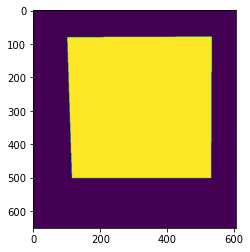

In [304]:
import matplotlib.pyplot as plt
plt.imshow(image_vec)